In [70]:
import pandas
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [71]:
inputFolder='../data/'
trainFolder=inputFolder+'train/'
testFolder=inputFolder+'test/'

(1）数据总体概述     参赛者可用的训练数据包括用户的基本属性user_info.txt、银行流水记录bank_detail.txt、用户浏览行为browse_history.txt、信用卡账单记录bill_detail.txt、放款时间loan_time.txt，以及这些顾客是否发生逾期行为的记录overdue.txt。（注意：并非每一位用户都有非常完整的记录，如有些用户并没有信用卡账单记录，有些用户却没有银行流水记录。）     相应地，还有用于测试的用户的基本属性、银行流水、信用卡账单记录、浏览行为、放款时间等数据信息，以及待预测用户的id列表。     脱敏处理：(a) 隐藏了用户的id信息；(b) 将用户属性信息全部数字化；(c) 将时间戳和所有金额的值都做了函数变换。 2）数据详细描述 （1）用户的基本属性user_info.txt。共6个字段，其中字段性别为0表示性别未知。     用户id,性别,职业,教育程度,婚姻状态,户口类型     6346,1,2,4,4,2     2583,2,2,2,2,1     9530,1,2,4,4,2     6707,0,2,3,3,2 

（2）银行流水记录bank_detail.txt。共5个字段，其中，第2个字段，时间戳为0表示时间未知；第3个字段，交易类型有两个值，1表示支出、0表示收入；第5个字段，工资收入标记为1时，表示工资收入。     用户id,时间戳,交易类型,交易金额,工资收入标记      6951,5894316387,0,13.756664,0     6951,5894321388,1,13.756664,0     18418,5896951231,1,11.978812,0     18418,5897181971,1,12.751543,0     18418,5897293906,0,14.456463,1

（3）用户浏览行为browse_history.txt。共4个字段。其中，第2个字段，时间戳为0表示时间未知。     用户id,时间戳,浏览行为数据,浏览子行为编号     34724,5926003545,172,1     34724,5926003545,163,4     34724,5926003545,38,7     67215,5932800403,163,4     67215,5932800403,138,4     67215,5932800403,109,7 

（4）信用卡账单记录bill_detail.txt。共15个字段，其中，第2个字段，时间戳为0表示时间未知。为方便浏览，字段以表格的形式给出。


 文件示例如下：
    用户id,账单时间戳,银行id,上期账单金额,上期还款金额,信用卡额度,本期账单余额,本期账单最低还款额,消费笔数,本期账单金额,调整金额,循环利息,可用金额,预借现金额度,还款状态
    3147,5906744363,6,18.626118,18.661937,20.664418,18.905766,17.847133,1,0.000000,0.000000,0.000000,0.000000,19.971271,0
    22717,5934018585,3,0.000000,0.000000,20.233635,18.574069,18.396785,0,0.000000,0.000000,0.000000,0.000000,0.000000,0
 （5）放款时间信息loan_time.txt。共2个字段，用户id和放款时间。
    用户id,放款时间
    1,5914855887
    2,5914855887
    3,5914855887
（6）顾客是否发生逾期行为的记录overdue.txt。共2个字段。样本标签为1，表示逾期30天以上；样本标签为0，表示逾期10天以内。注意：逾期10天~30天之内的用户，并不在此问题考虑的范围内。用于测试的用户，只提供id列表，文件名为testUsers.csv。
    用户id,样本标签
    1,1
    2,0
    3,1

In [72]:
trainUsers=pandas.read_csv(trainFolder+'user_info_train.txt', \
                           names=['id','sex','profession','education','marriage','citizen_type'],\
                          index_col=0).sort_index()

trainBanks=pandas.read_csv(trainFolder+'bank_detail_train.txt',\
                          names=['user_id', 'time', 'transaction_type', 'amount', 'is_salary'])

trainBrowse=pandas.read_csv(trainFolder+'browse_history_train.txt',\
                           names=['user_id', 'time', 'browse_type', 'sub_type'])

trainBills=pandas.read_csv(trainFolder+'bill_detail_train.txt',\
                          names=['user_id', 'time', 'bank_id', 'last_bill_amount', 'last_bill_pay', 'credit_line', 'cur_bill_balance', \
                                 'cur_bill_min_due', 'transactionNum', 'cur_bill_amount', 'adjusted_amount', 'cumulative_interest',\
                                 'available_deposit', 'available_credit', 'debt[_status'])

trainFundingTime=pandas.read_csv(trainFolder+'loan_time_train.txt',\
                                names=['user_id', 'time'], index_col=0).sort_index()

trainOverdue=pandas.read_csv(trainFolder+'overdue_train.txt',\
                            names=['user_id', 'label'], index_col=0).sort_index()

In [80]:
(trainBills['last_bill_amount']>0).sum()

1714985

In [44]:

testFundingTime=pandas.read_csv(testFolder+'loan_time_test.txt',\
                            names=['user_id', 'time'],index_col=0).sort_index()

In [57]:
trainBills['time'].min()

0

In [69]:
a=trainUsers[3300:]
a.index

Int64Index([ 3301,  3302,  3303,  3304,  3305,  3306,  3307,  3308,  3309,
             3310,
            ...
            55587, 55588, 55589, 55590, 55591, 55592, 55593, 55594, 55595,
            55596],
           dtype='int64', name=u'id', length=52296)

5932135887
5932135887


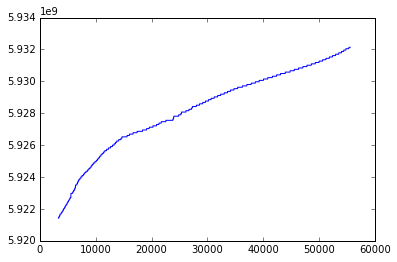

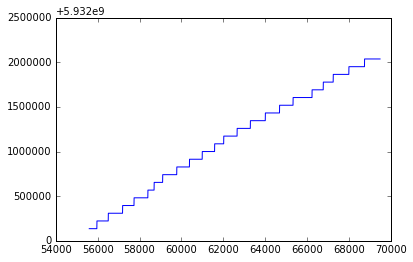

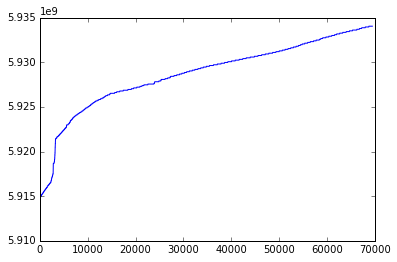

In [65]:
print trainFundingTime.time.unique().max()
print testFundingTime.time.unique().min()
plt.plot(trainFundingTime.time[3300:])
plt.figure()
plt.plot(testFundingTime.index, testFundingTime.time)
plt.figure()
allFT=pandas.concat([trainFundingTime, testFundingTime])
plt.plot(allFT.index, allFT.time)

In [52]:
print (trainBrowse['browse_type'].value_counts()>=1000).sum()

116


In [30]:
print trainBills[['cur_bill_amount', 'adjusted_amount']].head(20)

    cur_bill_amount  adjusted_amount
0          0.000000         0.000000
1          0.000000         0.000000
2          0.000000         0.000000
3          0.000000         0.000000
4          0.000000         0.000000
5          0.000000         0.000000
6          0.000000         0.000000
7          0.000000         0.000000
8         17.322724         0.000000
9         19.976445        18.659787
10         0.000000         0.000000
11        19.237914         0.000000
12         0.000000         0.000000
13        19.754017        20.181980
14         0.000000         0.000000
15        19.290633         0.000000
16         0.000000         0.000000
17         0.000000         0.000000
18        20.537050         0.000000
19         0.000000         0.000000


In [28]:
trainBanks[(trainBanks['is_salary']==1) & (trainBanks['transaction_type']==1)].head()

,user_id,time,transaction_type,amount,is_salary


In [24]:
print trainBills['debt_status'].unique()
print trainBanks[trainBanks['is_salary']==1][['amount']].head()
print 2*np.power((np.exp(trainBanks[trainBanks['is_salary']==1][['amount']])-1), 1.0/2).mean()


print 2*np.power((np.exp(trainBills[['last_bill_amount', 'last_bill_pay',  'credit_line', 'cur_bill_amount',\
                 'adjusted_amount']])-1), 1.0/2).head(100)

[0 1]
         amount
1632  14.847955
1684  14.717024
1740  14.637385
1785  14.911227
1824  14.931199
amount    2299.895925
dtype: float64
    last_bill_amount  last_bill_pay    credit_line  cur_bill_amount  \
0       22163.591000   22564.105640   61411.732567         0.000000   
1       25489.711458   25543.142837   61411.732567         0.000000   
2       28276.876874   28804.651922   61411.732567         0.000000   
3       31046.587517   31047.922549   72663.333311         0.000000   
4       51265.186743   51380.766037   72663.333311         0.000000   
5       37319.441106   38351.605840   61411.732567         0.000000   
6       46451.715681   47569.314533   75213.700452         0.000000   
7           0.000000       0.000000       0.000000         0.000000   
8       30094.694669   32965.395819   33636.587890     11550.790620   
9       38954.737696   31910.461400   97100.439482     43537.141463   
10      42002.930953   24564.686372   72663.333311         0.000000   
11      3

In [147]:
bills=trainBills.groupby('user_id')

In [175]:
banksOnbill=pandas.DataFrame({'bankNum':bills['bank_id'].nunique()})
banksOnbill['overdue']=trainOverdue.set_index('user_id')

bankNum
1     0.145796
2     0.134560
3     0.114722
4     0.101204
5     0.091159
6     0.086522
7     0.078643
8     0.089013
9     0.067885
10    0.098592
11    0.096774
12    0.115385
13    0.111111
14    0.200000
15    0.000000
17    0.000000
dtype: float64


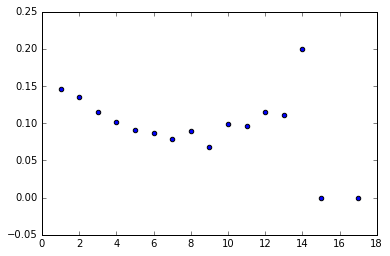

In [189]:
banks2Overdue=banksOnbill.groupby('bankNum').apply(lambda x: 1.0*x['overdue'].sum()/x['overdue'].count())
print banks2Overdue
plt.scatter(banks2Overdue.index, banks2Overdue)

In [139]:
userFeatures=trainUsers.copy()

bankRecordsPersonal=trainBanks.groupby('user_id')
userFeatures['transactionNum']=bankRecordsPersonal['amount'].count()
userFeatures['transactionAmount']=bankRecordsPersonal['amount'].sum()
userFeatures['salaryNum']=bankRecordsPersonal['is_salary'].sum()

browseRecordsPersonal=trainBrowse.groupby('user_id')
userFeatures['browseNum']=browseRecordsPersonal['time'].count()
userFeatures['browseTypes']=browseRecordsPersonal['browse_type'].nunique()
userFeatures['browseSubTypes']=browseRecordsPersonal.apply(lambda x: x.groupby('browse_type')['sub_type'].nunique().sum())

bills=trainBills.groupby('user_id')
userFeatures['billBanksNum']=bills['bank_id'].nunique()
userFeatures['billNum']=bills['time'].count()




In [91]:
print trainBills[trainBills.time>0].time.min(), trainBills['time'].max()

5746916127 5952662481


In [193]:
print 'users:'
print trainUsers['profession'].sort_values(inplace=False).unique()
print trainUsers['citizen_type'].sort_values(inplace=False).unique()
print trainUsers['marriage'].sort_values(inplace=False).unique()


print 'brank records:'
print 'number of different times: ', len(trainBanks['time'].sort_values(inplace=False).unique())
print 'number of transaction types: ', trainBanks['transaction_type'].sort_values(inplace=False).unique()
print 'number of is_salary types: ', trainBanks['is_salary'].sort_values(inplace=False).unique()

print 'browse history:'
print trainBrowse['browse_type'].sort_values(inplace=False).unique()
print trainBrowse['sub_type'].sort_values(inplace=False).unique()

print 'bill history:'
print trainBills['bank_id'].sort_values(inplace=False).unique()
print trainBills['debt_status'].sort_values(inplace=False).unique()

print 'funding time:'
print len(trainFundingTime['time'].unique())

print 'overdue:'
print trainOverdue['label'].unique()

users:
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4 5]
brank records:
number of different times:  1419542
number of transaction types:  [0 1]
number of is_salary types:  [0 1]
browse history:
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 20

0             38773
5879518287        1
5879863887        3
5880036687        4
5880295887        2
5880382287        1
5880436587        2
5880440061        2
5880468687        2
5880555087        2
5880641487        1
5880727887       20
5880814287        3
5880900687        7
5880987087        3
5881073487        4
5881159887        5
5881246287       37
5881332687       31
5881419087        2
Name: time, dtype: int64


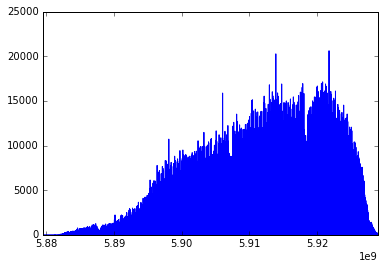

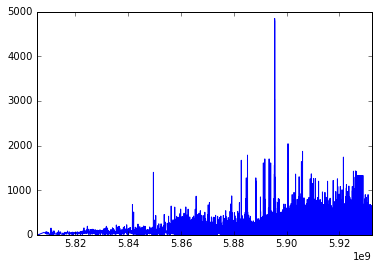

In [8]:
bankTimeCounts=trainBanks['time'].value_counts().sort_index()
print bankTimeCounts.head(20)
plt.figure(1)
bankTimeCounts[1:].plot()

browseTimeCounts=trainBrowse['time'].value_counts().sort_index()
plt.figure(2)
browseTimeCounts.plot()

cannot see much of frequency component in the transformed time stamp.  Cannot use periodic time as a feature.

In [10]:
bankTimeFreq=np.fft.fft(bankTimeCounts[1:])
browseTimeFreq=np.fft.fft(browseTimeCounts)

[ 0.]


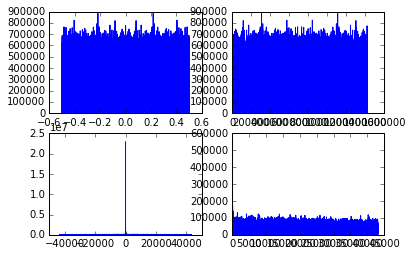

In [35]:
plt.subplot(221)
f=np.fft.fftfreq(len(bankTimeCounts[1:]),d=1.0)
plt.plot(f[1:], abs(bankTimeFreq[1:]))
plt.subplot(222)
plt.plot(abs(bankTimeFreq[1:]))

plt.subplot(223)
f=np.fft.fftfreq(len(browseTimeFreq),d=1.0/3600/24)
amp=abs(browseTimeFreq)
plt.plot(f, abs(browseTimeFreq))
plt.subplot(224)
plt.plot(f[f>1], amp[f>1])
print f[amp==amp.max()]

In [41]:
# print trainUsers.head()
# print trainBanks.head()

# print trainBrowse.head()
# print trainBills.head()

# print trainFundingTime.head()
# print trainOverdue.head()

print 'Total users: ', len(trainUsers)
print 'Unique users: ', len(trainUsers['id'].unique())
print 

print 'Total brank transactions: ', len(trainBanks)
print 'Unique users with bank transactions', len(trainBanks['user_id'].unique())
print

print 'Total browsing history: ', len(trainBrowse)
print 'Unique users with browsing history: ', len(trainBrowse['user_id'].unique())
print

print 'Total bills: ', len(trainBills)
print 'Unique users with bills', len(trainBills['user_id'].unique())
print

print 'Total fundings: ', len(trainFundingTime)
print 'Unique users in fundings', len(trainFundingTime['user_id'].unique())
print 

print 'Total overdue records: ', len(trainOverdue) 
print 'Unique users in overdue records',len(trainOverdue['user_id'].unique())


Total users:  55596
Unique users:  55596

Total brank transactions:  6070197
Unique users with bank transactions 9294

Total browsing history:  22919547
Unique users with browsing history:  47330

Total bills:  2338118
Unique users with bills 53174

Total fundings:  55596
Unique users in fundings 55596

Total overdue records:  55596
Unique users in overdue records 55596
